In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq
import pylab as pl
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
#import sys
#!{sys.executable} -m pip install pmdarima
#import pmdarima as pm
#!{sys.executable} -m pip install tensorflow_probability
#import tensorflow.compat.v2 as tf
#from tensorflow_probability import sts
#import tensorflow_probability as tfp

#from tensorflow_probability import distributions as tfd

#import collections
#tf.enable_v2_behavior()

## Content
- Update on Google Trends model
    - Stationary Test
    - Data 
- Evaluation metrics
    - Rolling training
- Stacking
    - Linear Combined
    - Combination in Bayesian Structure Time Series model
    


## 1. Update on Google Trends model

### 1.1 Stationarity Test

In milestone 2, the prediction target in google trends model is the listing data it self. However, since it is a time series target, a stationarity test is necessary to suggest whether the target itself or which order difference should be used. We will use unit root (Augmented Dickey-Fuller) test here.

In [2]:
url = 'https://drive.google.com/file/d/19_JeXh3Ost8q7XyX-ZmnDPLCLKy7HC00/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
df1 = pd.read_csv(dwn_url)

In [3]:
df1['sale_month'] = df1.sale_date.apply(lambda x: str(x)[:-3])
df1['list_month'] = df1.list_date.apply(lambda x: str(x)[:-3])
df_listing = df1.groupby(["list_month"]).agg({"property_id":"count"}).reset_index()
df_listing = df_listing.rename(columns={"property_id":"count_list"})

df_sale = df1.groupby(["sale_month"]).agg({"property_id":"count", "sale_price":"sum"}).reset_index()
df_sale = df_sale.rename(columns={"property_id":"count_sale"})

monthData = pd.merge(df_listing, df_sale, left_on = ['list_month'], right_on = ['sale_month'])
monthData = monthData.drop('list_month', axis=1)
monthData = monthData.rename(columns={'sale_month':'month'})
monthData = monthData.iloc[:-1,:]
monthData.tail()

,count_list,month,count_sale,sale_price
50,14520,2020-05,4805,2.379073e+09
51,14574,2020-06,7728,3.903482e+09
52,14901,2020-07,9019,4.842772e+09
53,13734,2020-08,9029,4.808662e+09
54,13626,2020-09,8325,4.464710e+09


In [4]:
monthData['count_list'].loc[39] = (monthData['count_list'].loc[38]+monthData['count_list'].loc[40])/2

In [9]:
monthData.to_csv('monthData.csv')
#monthData = pd.read_csv('monthData.csv')

In [5]:
from statsmodels.tsa.stattools import adfuller
result= adfuller(monthData['count_list'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.444738
p-value: 0.560650
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


The p value is large, and the ADF Statistic is larger than the 10% Critical value. Thus, the number of listings has a unit root and is non-stationary.

In [6]:
result= adfuller(monthData['count_sale'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.529076
p-value: 0.985731
Critical Values:
	1%: -3.593
	5%: -2.932
	10%: -2.604


The p value is large, and the ADF Statistic is larger than the 10% Critical value. Thus, the number of sales has a unit root and is non-stationary.

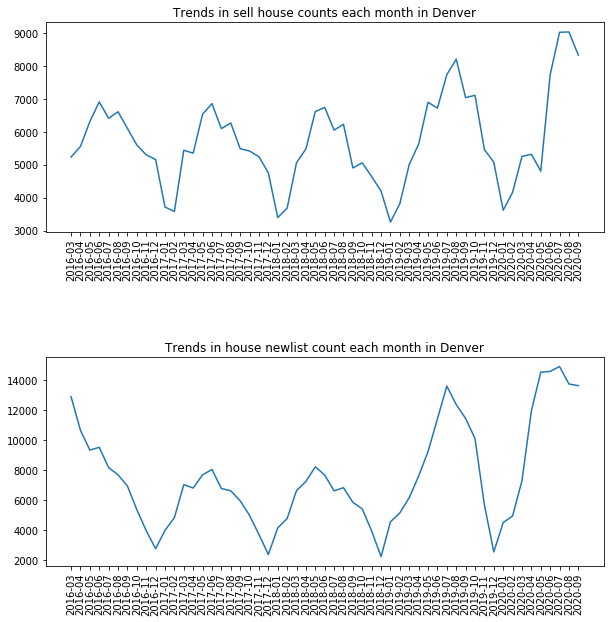

In [7]:
fig,ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(monthData.month,monthData['count_sale'])
ax[0].set_title('Trends in sell house counts each month in Denver')
ax[0].set_xticklabels(monthData['month'],rotation = 90)
ax[1].plot(monthData.month,monthData['count_list'])
ax[1].set_title('Trends in house newlist count each month in Denver')
ax[1].set_xticklabels(monthData['month'],rotation = 90)
plt.subplots_adjust(hspace=0.6)

If we try to predict the one order difference. Check the stationarity then.


In [37]:
result= adfuller(monthData['count_list'].diff(-3).values[:-3])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.098749
p-value: 0.245018
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


In [36]:
result= adfuller(monthData['count_sale'].diff(-3).values[:-3])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.373716
p-value: 0.149293
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


The p values are small, and the ADF statistics are smaller. Thus, the one order difference sequences for number of listing and number of sales are stationary.

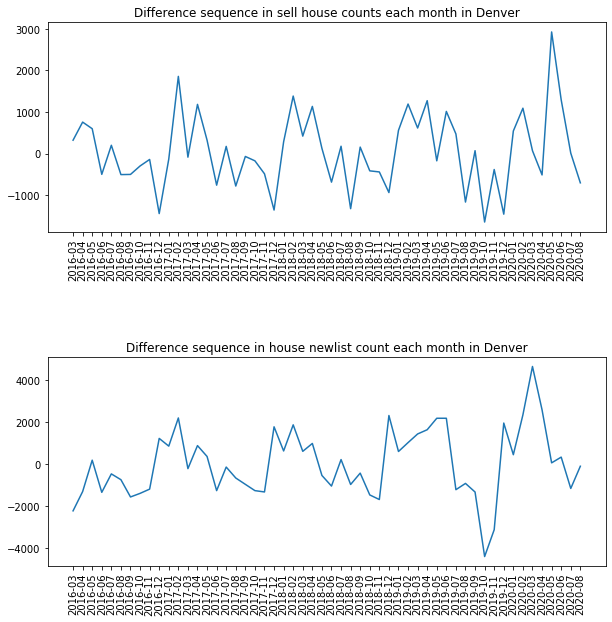

In [10]:
fig,ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(monthData['month'][1:],monthData['count_sale'].diff(1)[1:])
ax[0].set_title('Difference sequence in sell house counts each month in Denver')
ax[0].set_xticklabels(monthData['month'],rotation = 90)
ax[1].plot(monthData['month'][1:],monthData['count_list'].diff(1)[1:])
ax[1].set_title('Difference sequence in house newlist count each month in Denver')
ax[1].set_xticklabels(monthData['month'],rotation = 90)
plt.subplots_adjust(hspace=0.6)

Therefore, we will use the difference number between prediction month and current month as our final prediction in Google Trends model. That is, if we want to predict the number 3 months later, we will use the difference between the number in 3 months and the current number as our prediction.

In [12]:
result= adfuller(monthData['count_list'].diff(1).iloc[1:].diff(1).values[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.171011
p-value: 0.021725
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606


In [14]:
result= adfuller(monthData['count_sale'].diff(1).iloc[1:].diff(1).values[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.295253
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


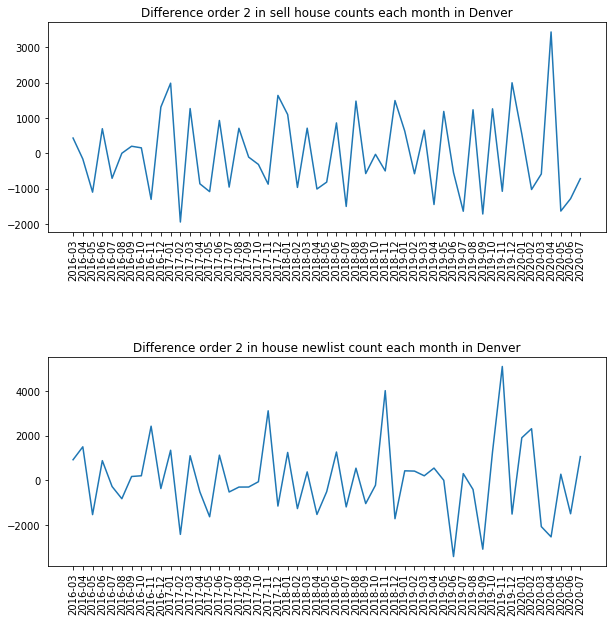

In [16]:
fig,ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(monthData['month'][2:],monthData['count_sale'].diff(1)[1:].diff(1).values[1:])
ax[0].set_title('Difference order 2 in sell house counts each month in Denver')
ax[0].set_xticklabels(monthData['month'],rotation = 90)
ax[1].plot(monthData['month'][2:],monthData['count_list'].diff(1)[1:].diff(1).values[1:])
ax[1].set_title('Difference order 2 in house newlist count each month in Denver')
ax[1].set_xticklabels(monthData['month'],rotation = 90)
plt.subplots_adjust(hspace=0.6)

In [18]:
monthData.to_csv('monthData_revised.csv')

### 1.2 Acquire averaged Google Trends data 

The number of google trends acquired by API is different in each time, that is because we can only get the partial data by google. Since the model is sensitive to the trends data, we acquire the google trends data for number of times(100 times), and use the average of it, to get a more stable data source.

In [6]:
Keywords_with_high_imrpessions = [
    ['homes for sale', 'homes for sale in', 'properties for sale','for sale home','homes for sales'], #home for sale
    ['townhomes for sale','townhouses for sale','townhouse for sale'], #townhomes for sale
    'Homes in', 
    'townhouses in',  
    'Homes near me', 
    'condominium for sale near me', 

    'zillow homes for sale',
                
    ['selling a house','sell home', 'selling your home'], #sell homes
     
    ['house appraisal','home appraisal'],#home appraisal
    
    ['home values', 'home valuations', 'home value', 'value of home'],#home values
    ['house valuations','house value', 'house valuation', 'value of house'],#house values
    'property value',
    'real estate values', 
    
    ['home value estimator','estimate property value'],  #home value estimator
     
    ['how much is my house','how much is my house worth',  'price my house', 'how much can i sell my house for'],  #how much is my house
    'home worth',
       
    ['house prices','house price', 'home prices', 'sold home prices'],#home price
                 
    ['rexhomes', 'rex real estate', 'rex home', 'rex house','rex homes'], #rex home
    ['zillow', 'zillow com','zillows'], #zillow.com
    ['real estate agents',  'listing agent'], #agents
    'best realtors',
    ['low commission real estate agents','low commission real estate'],   #low commission real estate
    'how to sell a house without a realtor',
    
                 
    ['for sale by owner', 'fsbo'], #for sale by owner
    'redfin', 
    'trulia', 
    'realtor.com',
    
    ['Homes in Denver', 'townhouses in Denver','houses in Denver'],#homes in denver
    ['selling a house in Denver','sell home in Denver', 'selling your home in Denver','homes for sale in Denver'],#Homes for sale in denver             
    ['house appraisal in Denver', 'home values in Denver', 'house price in Denver'],  #house appraisal in denver                
    'for sale by owner in Denver']

In [4]:
# set up google trends api
grouper = pd.Grouper(level='date', freq='M')
pytrends = TrendReq(hl='en-US', tz=360)
def get_keyword_to_time_series(keywords,geo='US-CO',return_columns = False):
    keyword_to_time_series = {}
    keywords_columns = []
    for keyword in keywords:
        time.sleep(10)
        if type(keyword) == list:
            pytrends.build_payload(keyword, cat=0, timeframe='2016-03-01 2020-09-30', geo=geo)
            pytrends_df = pytrends.interest_over_time()
            if len(pytrends_df)!=0: 
                pytrends_monthly_df = pytrends_df.groupby(grouper)[keyword].mean().reset_index()
                time_series = np.mean(np.array(pytrends_monthly_df[keyword]),axis=1)
                keyword_to_time_series[keyword[0]] = time_series
                keywords_columns.append(keyword[0])
                #print(keyword)
        else:
            pytrends.build_payload([keyword], cat=0, timeframe='2016-03-01 2020-09-30', geo=geo)
            pytrends_df = pytrends.interest_over_time()
            if len(pytrends_df)!=0: 
                pytrends_monthly_df = pytrends_df.groupby(grouper)[keyword].mean().reset_index()
                time_series = np.array(pytrends_monthly_df[keyword])
                keyword_to_time_series[keyword] = time_series
                keywords_columns.append(keyword)
    if return_columns == True:
        return keyword_to_time_series, keywords_columns
    else:
        return keyword_to_time_series

In [80]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=300)

In [109]:
pytrends.build_payload(['sale'], cat=0, timeframe='2016-03-01 2020-09-30', geo='US-CO')
pytrends_df = pytrends.interest_over_time()

In [88]:
pytrends = TrendReq(hl='en-US', tz=360)

In [ ]:
import time
keyword_to_time_series, keywords_columns = get_keyword_to_time_series(Keywords_with_high_imrpessions,geo='US-CO',return_columns=True)
for i in range(19):
    keyword_to_time_series_1 = get_keyword_to_time_series(Keywords_with_high_imrpessions,geo='US-CO')
    for keyword in keywords_columns:
        keyword_to_time_series[keyword] = keyword_to_time_series[keyword]+keyword_to_time_series_1[keyword]
    print(i+1)

In [ ]:
keyword_to_time_series_1 = get_keyword_to_time_series(Keywords_with_high_imrpessions,geo='US-CO')

In [81]:
trend = pd.DataFrame(keyword_to_time_series, index=monthData.month.values).reset_index()
trend

55

## 2. Stacking Time Series and Google Trends model

### 2.1 Evaluation metrics

One difficulty in evaluation models for Google Trends and time series model is that the target is a time series. We want to train the time series model by the history data, as well as evaluate the model performance and check the stationarity. Thus we use the nested cross validation mean squared error to evaluate models. 

![jupyter](nested_cross_validation.png)

In [200]:
def model_split(x, y, cv=5,return_idx = False, time_cv=None): #cv is the k-fold number
    time_periods = len(x)
    if time_cv ==None:
        time_cv = time_periods//cv #time periods length in a single training set
    elif time_cv!=time_periods//cv:
        cv = np.ceil(time_periods//time_cv)
    groups_train = {}
    groups_test = {}
    split_idx = []
    for i in range(cv-2):
        groups_train[i] = (x[:(i+1)*time_cv], y[:(i+1)*time_cv])
        groups_test[i] = (x[(i+1)*time_cv:(i+2)*time_cv], y[(i+1)*time_cv:(i+2)*time_cv])
        split_idx.append((i+1)*time_cv)
    groups_train[cv-2] = (x[:(cv-1)*time_cv], y[:(cv-1)*time_cv])
    groups_test[cv-2] = (x[(cv-1)*time_cv:], y[(cv-1)*time_cv:])
    split_idx.append((cv-1)*time_cv)
    if return_idx == False:
        return groups_train, groups_test
    else:
        return groups_train, groups_test, split_idx

def model_evaluation(model, groups_train, groups_test, cv):
    scores = []
    preds = []
    for i in range(cv-1):
        model_copy = model
        #print(len(groups_train), time_cv)
        print('train time : ', i+1)
        #print(groups_train[i][0])
        model_copy.fit(groups_train[i][0], groups_train[i][1])
        pred = model_copy.predict(groups_test[i][0])
        mse = mean_squared_error(groups_test[i][1], pred)
        scores.append(mse)
        print(mse)
        preds.extend(list(pred))
    
    return preds, scores


def nested_cv_evaluation(model,x,y,cv=5):
    groups_train, groups_test = model_split(x,y,cv)
    preds, scores = model_evaluation(model,groups_train, groups_test, cv)
    return preds, scores


### 2.2 Rolling Training

## "Is order 1 difference as target performs really better?" in google trends?

In [129]:
import tensorflow.compat.v2 as tf
from tensorflow_probability import sts
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

In [130]:
#Step 1:  evaluate the time series model
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    return model

def build_variational_posteriors(model, training_data, nsamples,
                                 optimizer = tf.optimizers.Adam(learning_rate=.05),
                                 plot = True
                                ):
    # Build the variational surrogate posteriors `qs`.
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

    # Allow external control of optimization to reduce test runtimes.
    num_variational_steps = 200 # @param { isTemplate: true}
    num_variational_steps = int(num_variational_steps)
    # Using fit_surrogate_posterior to build and optimize the variational loss function.
    @tf.function(experimental_compile=True)
    def train():
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_log_prob(observed_time_series=training_data),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
        return elbo_loss_curve

    elbo_loss_curve = train()
    
    if plot:
        plt.plot(elbo_loss_curve)
        plt.title("ELBO loss curve")
        plt.show()

    # Draw samples from the variational posterior.
    q_samples = variational_posteriors.sample(nsamples)
    
    return q_samples

class BTSM(object):
    def __init__(self,):
        self.model = 0
        self.q_samples = 0
        
    def fit(self,x_train, y_train):
        self.train = x_train
        self.model = build_model(x_train)
        self.q_samples = build_variational_posteriors(self.model, x_train,len(x_train),
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = False)
        
        
    def predict(self,x_test,num_samples=100):
        forecast_dist = tfp.sts.forecast(self.model, observed_time_series=self.train,
                                            parameter_samples=self.q_samples, num_steps_forecast=len(x_test))

        forecast_mean, forecast_scale, forecast_samples = (forecast_dist.mean().numpy()[..., 0],
                                                           forecast_dist.stddev().numpy()[..., 0],
                                                           forecast_dist.sample(num_samples).numpy()[..., 0])
        return forecast_mean
        
sales = monthData['count_sale'].values.astype(float)
lists = monthData['count_list'].values.astype(float)

In [513]:
bmodel = BTSM()
bmodel.fit(sales,0)
pred_sales = bmodel.predict(np.ones(6))


In [514]:
bmodel = BTSM()
preds,scores = nested_cv_evaluation(bmodel,sales,sales,cv=9)

train time :  1
8764421.730315119
train time :  2
5650013.43931545
train time :  3
56430.92672288004
train time :  4
43066.08436514023
train time :  5
219244.59254219718
train time :  6
942162.167720717
train time :  7
4773891.826156495
train time :  8
2584119.4685808877


In [515]:
groups_train, groups_test, split_idx = model_split(sales, sales, cv=9, return_idx=True)
split_idx

[6, 12, 18, 24, 30, 36, 42, 48]

The net cross validation mse score is:  1712496.8278730877


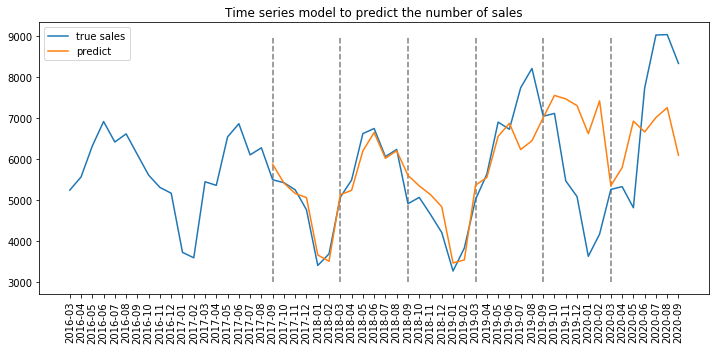

In [516]:
print('The net cross validation mse score is: ', np.mean(scores[3:]))
plt.figure(figsize=(12,5))
plt.plot(monthData.month, list(sales),label ='true sales')
plt.plot(monthData.month[18:], preds[12:],label='predict')
plt.vlines(np.array(split_idx[2:]),ymin=3000, ymax=9000,alpha=0.5,linestyle='--')
plt.title('Time series model to predict the number of sales')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months

In [517]:
bmodel1 = BTSM()
preds1,scores1 = nested_cv_evaluation(bmodel1,lists,lists,cv=9)

train time :  1
1825608.095241349
train time :  2
48469044.69719706
train time :  3
360550.13590409374
train time :  4
1061859.5562363404
train time :  5
204016.06020977898
train time :  6
57677608.33473608
train time :  7
63573374.837060414
train time :  8
22461217.515571915


The net cross validation mse score is:  28995615.260762908


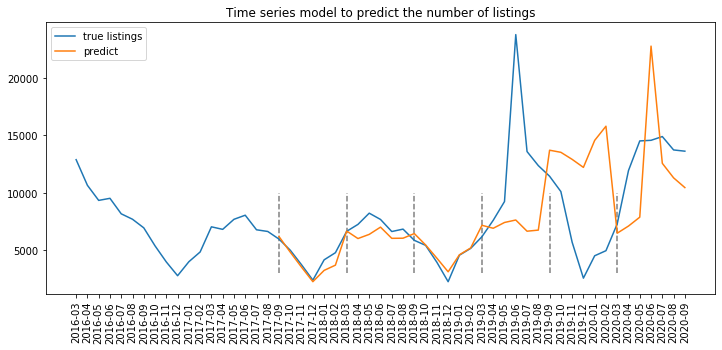

In [518]:
print('The net cross validation mse score is: ', np.mean(scores1[3:]))
plt.figure(figsize=(12,5))
plt.plot(monthData.month, list(lists),label ='true listings')
plt.plot(monthData.month[18:], preds1[12:],label='predict')
plt.vlines(np.array(split_idx[2:]),ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Time series model to predict the number of listings')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months

In [26]:
#Step 2: evaluate the google trends model
monthData = pd.read_csv('monthData_revised.csv')
trend = pd.read_csv('google_trends_scaled.csv')
merged = pd.merge(monthData, trend, left_on ='month', right_on='month').drop(['Unnamed: 0_x','Unnamed: 0_y'],axis=1)
merged
#merged.columns

,count_list,month,count_sale,sale_price,homes for sale,townhomes for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,...,real estate agents,best realtors,for sale by owner,redfin,trulia,realtor.com,Homes in Denver,selling a house in Denver,house appraisal in Denver,for sale by owner in Denver
0,12885.0,2016-03,5234,2.059187e+09,71.279751,45.731855,100.000000,100.000000,1.152516,9.873854,...,83.028011,79.206349,71.950667,13.663482,97.084922,32.608612,83.900580,78.686142,28.608541,90.457331
1,10650.0,2016-04,5555,2.242159e+09,65.377771,73.121023,99.892689,28.638918,2.927375,6.588620,...,100.000000,41.129426,56.327748,18.038512,93.422996,44.912573,90.410047,100.000000,66.930681,70.116575
2,9334.0,2016-05,6311,2.627671e+09,67.316675,36.406112,86.215481,64.991447,0.000000,3.374172,...,35.888193,32.573871,63.168269,18.718533,87.575279,44.453392,68.627062,67.838093,49.408187,88.828277
3,9515.0,2016-06,6908,2.962638e+09,59.772373,92.568674,81.728430,55.884988,5.284968,13.172702,...,38.098334,42.985348,57.792813,12.829219,95.711054,38.489781,55.316301,48.005232,14.402484,72.612465
4,8163.0,2016-07,6408,2.684241e+09,61.815081,95.738568,84.635856,40.320925,4.728896,18.482621,...,32.134499,16.735043,61.127834,12.576029,79.179192,48.134514,58.333747,98.510283,52.459764,82.670752
5,7690.0,2016-08,6607,2.716282e+09,49.269667,55.532880,63.621405,82.316527,4.496565,16.339958,...,47.813497,48.778999,40.944567,6.674104,60.858202,38.518540,58.262914,53.586222,0.000000,80.227171
6,6940.0,2016-09,6101,2.457247e+09,38.933788,24.458258,42.838747,43.324917,8.171971,22.679009,...,20.960879,3.015873,29.150795,1.750982,53.715124,31.640400,48.378300,61.986774,13.439361,86.055896
7,5367.0,2016-10,5599,2.261839e+09,28.381404,25.461185,39.078552,57.093753,3.720349,11.200653,...,18.065241,10.336996,15.806718,7.314352,48.954105,22.562215,100.000000,68.814766,17.939425,48.379913
8,3965.0,2016-11,5300,2.165577e+09,6.636020,14.200746,12.197739,26.952839,0.147016,0.000000,...,10.300201,71.819292,11.523401,0.000000,32.058632,3.015836,39.556166,36.654313,56.298315,77.282917
9,2766.0,2016-12,5158,2.090737e+09,0.000000,29.493032,0.000000,59.916918,5.604900,2.500227,...,38.659733,7.820513,13.594470,0.635398,33.737230,0.403581,27.553673,14.432091,35.927005,77.170826


### A. Model prediction with no difference: model target: 3 month in the future

In [ ]:
#predictors: current, lag1, lag3 for google trends, current, lag1, lag3 of count of sales/listings, month of a year t
feature_column_names = merged.columns.delete(1)
f = merged.columns.delete(1)
for i, col in enumerate(f):
    #print(col)
    merged[col+'_lag1'] = merged[col].diff(1)
    merged[col+'_lag2'] = merged[col].diff(2)
    feature_column_names = np.append(feature_column_names,str(col)+'_lag1')
    feature_column_names = np.append(feature_column_names,str(col)+'_lag2')
merged['t'] = merged['month'].apply(lambda x: str(x[-2:])+'m')
one_hot_month = pd.get_dummies(merged['t'])
feature_column_names = np.append(feature_column_names,one_hot_month.columns)
merged = merged.join(one_hot_month)

In [29]:
merged['count_sale_target'] = merged['count_sale'].shift(-3)
merged['count_list_target'] = merged['count_list'].shift(-3)

In [30]:
target_column_names = ['count_sale_target', 'count_list_target']
len(feature_column_names)

105

In [32]:
merged = merged.dropna(axis=0)
train_X, test_X, train_y, test_y = train_test_split(merged[feature_column_names],merged[target_column_names], test_size = 0.2, random_state=100, shuffle=False)
#standardize the features
std = StandardScaler()
std.fit(train_X)
train_X_std =std.transform(train_X)
test_X_std = std.transform(test_X)

In [33]:
#lasso for sales
lr = LassoCV()
lr.fit(train_X_std, train_y['count_sale_target'])
selected_features_sale = feature_column_names[abs(lr.coef_)>0]
selected_features_sale_no = abs(lr.coef_)>0
selected_features_sale

array(['townhomes for sale', 'zillow', 'best realtors', 'count_list_lag1',
       'count_list_lag2', 'sale_price_lag1', 'Homes near me_lag2',
       'zillow_lag2', 'realtor.com_lag2', '05m', '10m', '11m'],
      dtype=object)

In [521]:
class PCA_KNN_model(object):
    def __init__(self,n_neighbors=2):
        self.model = np.nan
        self.n_neighbors = n_neighbors
    def fit(self,x_train,y_train):
        self.model = KNeighborsRegressor(n_neighbors=self.n_neighbors)
        self.std = StandardScaler()
        x_train_std = self.std.fit_transform(x_train)
        self.pca = PCA(n_components=4)
        x_train_pca = self.pca.fit_transform(x_train_std)
        self.model.fit(x_train_pca, y_train)
    def predict(self,x_test):
        #print(x_test)
        x_test_std = self.std.transform(x_test)
        x_test_pca = self.pca.transform(x_test_std)
        return self.model.predict(x_test_pca)

In [522]:
class PCA_KNN_rolling_model(object):
    def __init__(self,n_neighbors=2,predict_horizon=6,start_fit=2):
        self.models = {}
        self.n_neighbors = n_neighbors
        self.predict_horizon = predict_horizon
        self.start_fit = start_fit
    def fit(self,x_train,y_train):
        for i in range(1,self.predict_horizon+1):
            self.x_train = x_train
            self.y_train = y_train
            self.models[i] = PCA_KNN_model(self.n_neighbors)
            y = y_train.diff(i).shift(-i)[self.start_fit:-i]
            x = x_train[self.start_fit:-i]
            self.models[i].fit(x,y)
    def predict(self):
        y_pred = []
        for i in range(1,self.predict_horizon+1):
            pred_temp = self.models[i].predict(self.x_train[-2:])
            y_pred.append(pred_temp[-1]+self.y_train.iloc[-1])
        return y_pred

In [523]:
prediction_col = 'count_sale'
groups_train, groups_test, split_idx= model_split(merged[feature_column_names],merged[prediction_col],cv=9,return_idx=True)
split_idx


[6, 12, 18, 24, 30, 36, 42, 48]

In [524]:
pred_google_store = []
for i in range(6):
    #print(i)
    m = PCA_KNN_rolling_model()
    x = groups_train[i+2][0]
    y = groups_train[i+2][1]
    m.fit(x,y) 
    pred_google = m.predict()
    pred_google_store.extend(pred_google)

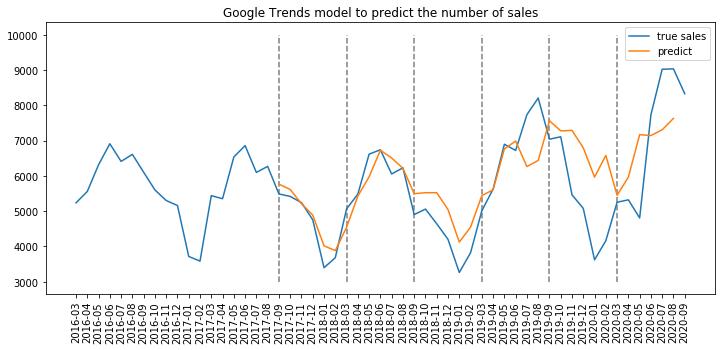

In [525]:
plt.figure(figsize=(12,5))
plt.plot(monthData.month, sales,label ='true sales')
plt.plot(monthData.month[18:-1], pred_google_store,label='predict')
plt.vlines(np.array(split_idx[2:]),ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Google Trends model to predict the number of sales')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months

In [502]:
class Lasso_Tree_model(object):
    def __init__(self,params=None):
        self.model = np.nan
        self.selected_features_list_no = np.nan
        
    def train_params(self,x_train,y_train):
        self.std = StandardScaler()
        x_train_std = self.std.fit_transform(x_train)
        lr = Lasso(alpha=700)
        lr.fit(x_train_std,y_train)
        self.selected_features_list_no = abs(lr.coef_)>0
    def fit(self,x_train,y_train):
        self.std = StandardScaler()
        x_train_std = self.std.fit_transform(x_train)
        #self.selected_features_list = feature_column_names[abs(lr.coef_)>0]
        print(sum(self.selected_features_list_no))
        self.model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=1, min_samples_split=3)
        self.model.fit(x_train_std[:,self.selected_features_list_no], y_train)
    def predict(self,x_test):
        #print(x_test)
        x_test_std = self.std.transform(x_test)
        return self.model.predict(x_test_std[:,self.selected_features_list_no])

In [503]:
class Lasso_Tree_rolling_model(object):
    def __init__(self,predict_horizon=6,start_fit=2, params=None):
        self.models = {}
        self.predict_horizon = predict_horizon
        self.start_fit = start_fit
    def train_params(self,x_train, y_train):
        for i in range(1,self.predict_horizon+1):
            self.models[i] = Lasso_Tree_model()
            y = y_train.diff(i).shift(-i)[self.start_fit:-i]
            x = x_train[self.start_fit:-i]
            self.models[i].train_params(x,y)
    def fit(self,x_train,y_train):
        self.x_train = x_train
        self.y_train = y_train
        for i in range(1,self.predict_horizon+1):
            y = y_train.diff(i).shift(-i)[self.start_fit:-i]
            x = x_train[self.start_fit:-i]
            self.models[i].fit(x,y)
    def predict(self):
        y_pred = []
        for i in range(1,self.predict_horizon+1):
            pred_temp = self.models[i].predict(self.x_train[-2:])
            y_pred.append(pred_temp[-1]+self.y_train.iloc[-1])
        return y_pred

In [504]:
prediction_col = 'count_list'
groups_train, groups_test, split_idx= model_split(merged[feature_column_names],merged[prediction_col],cv=9,return_idx=True)
split_idx

[6, 12, 18, 24, 30, 36, 42, 48]

In [505]:
pred_google_store1 = []
for i in range(6):
    m = Lasso_Tree_rolling_model()
    m.train_params(merged[feature_column_names], merged[prediction_col])
    m.fit(groups_train[i+2][0],groups_train[i+2][1])
    pred_google =  m.predict()
    pred_google_store1.extend(pred_google)

5
10
13
12
11
6
5
10
13
12
11
6
5
10
13
12
11
6
5
10
13
12
11
6
5
10
13
12
11
6
5
10
13
12
11
6


In [ ]:
plt.figure(figsize=(12,5))
plt.plot(monthData.month, lists,label ='true listings')
plt.plot(monthData.month[18:-1], pred_google_store1,label='predict')
plt.vlines(np.array(split_idx[2:]),ymin=3000, ymax=20000,alpha=0.5,linestyle='--')
plt.title('Google Trends model to predict the number of listings')
plt.xticks(rotation=90)
plt.legend()

### 2.2 Stacking methods

The stacking agorithm will also take in the nested cross validation idea. This time, the rolling training and prediction will be conduct, and we will receive a series of rolling-trained out-sample predictions for both Time Series and Googel Trends model. Then we will build another model, based on the predictions in two models, and the target. To avoid overfitting, we will use a relatively simple model (like linear), to combine the two models. 

In [548]:
#linear combination
x2 = pred_google_store
x1 = preds[12:-1]
y = sales[18:-1]
lr = LinearRegression()
lr.fit(np.concatenate([[x1],[x2]]).T, y)
print(lr.coef_)
print(lr.intercept_)
lr.score(np.concatenate([[x1],[x2]]).T, y)

[-0.72441396  1.83355623]
-1018.677047006111


0.5735821908863574

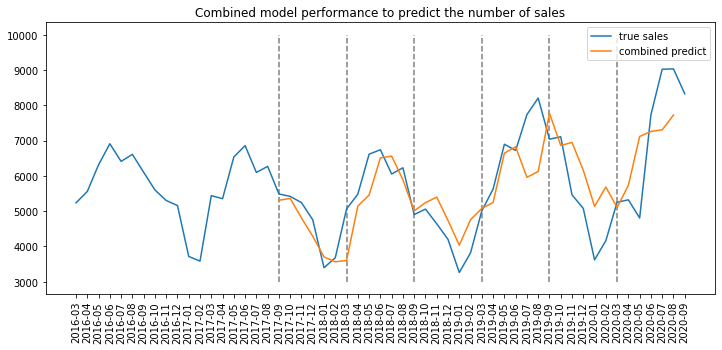

In [552]:
#final prediction
prediction = -0.72*np.array(x1) + 1.83*np.array(x2)-1018.67
plt.figure(figsize=(12,5))
plt.plot(monthData.month, sales,label ='true sales')
plt.plot(monthData.month[18:-1], prediction,label='combined predict')
plt.vlines(np.array(split_idx[2:]),ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
#plt.plot(monthData.month[18:-1], x2,label='google trends predict', linestyle ='--')
#plt.plot(monthData.month[18:-1], x1,label='time series predict', linestyle ='--')
plt.title('Combined model performance to predict the number of sales')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months


In [549]:
#mse calculation
print('The mse in time series model :', mean_squared_error(y,x1))
print('The mse in google trends model :', mean_squared_error(y,x2))
print('The mse in combined model :', mean_squared_error(y,-0.72*np.array(x1) + 1.83*np.array(x2)-1018.67))


The mse in time series model : 1368917.7202674372
The mse in google trends model : 1098094.2847222222
The mse in combined model : 934142.3082617968


## Update1: Nested Cross Validation 


In [103]:
def model_split(x, y, cv=5,return_idx = False, time_cv=None): #cv is the k-fold number
    time_periods = len(x)
    if time_cv ==None:
        time_cv = time_periods//cv  #time_cv is the time periods length in a single training set
    elif time_cv!=time_periods//cv: 
        cv = np.ceil(time_periods//time_cv)
    groups_train = {}
    groups_test = {}
    split_idx = []
    for i in range(cv-1):
        groups_train[i] = (x[:(i+1)*time_cv], y[:(i+1)*time_cv])
        groups_test[i] = (x[(i+1)*time_cv:(i+2)*time_cv], y[(i+1)*time_cv:(i+2)*time_cv])
        split_idx.append((i+1)*time_cv)
    groups_train[cv-1] = (x[:cv*time_cv], y[:cv*time_cv])
    groups_test[cv-1] = (x[cv*time_cv:], y[cv*time_cv:])
    split_idx.append(cv*time_cv) #split_idx is the index of the begining of test groups
    if return_idx == False:
        return groups_train, groups_test
    else:
        return groups_train, groups_test, split_idx

def model_evaluation(model, groups_train, groups_test, cv, show_CI_percent=None, bootstrap=1000):
    scores = []
    preds = []
    lower = []
    upper = []
    for i in range(cv):
        model_copy = model
        print('train time : ', i+1)
        model_copy.fit(groups_train[i][0], groups_train[i][1])
        pred = model_copy.predict(groups_test[i][0])
        mse = mean_squared_error(groups_test[i][1], pred)
        scores.append(mse)
        print(mse)
        preds.extend(list(pred))
        if show_CI_percent!=None:
            preds_boot = []
            train_length = len(groups_train[i][1])
            for j in range(bootstrap):
                indices = np.random.choice(np.arange(train_length),train_length, replace=True)
                model_copy = model
                model_copy.fit(groups_train[i][0][indices,:],groups_train[i][1][indices])
                preds_boot.append(model_copy.predict(groups_test[i][0]))
            #print(np.array(preds_boot).shape)
            upper.extend(list(np.percentile(np.array(preds_boot),100-show_CI_percent/2, axis=0)))
            lower.extend(list(np.percentile(np.array(preds_boot),show_CI_percent/2, axis=0)))
    if show_CI_percent == None:
        return preds, scores
    else:
        return np.array(preds), scores, np.array(upper), np.array(lower)

def nested_cv_evaluation(model,x,y,cv=5, start_pred=3, show_CI_percent = None):
    if show_CI_percent == None:
        groups_train, groups_test = model_split(x,y,cv)
        preds, scores = model_evaluation(model,groups_train, groups_test, cv)
        return preds, scores
    else:
        groups_train, groups_test = model_split(x,y,cv)
        preds, scores, upper, lower = model_evaluation(model, groups_train, groups_test,cv, show_CI_percent)
        return preds, scores, upper, lower


### Nested Cross Validation -- Google Trends

In [39]:
trend = pd.read_csv('google_trends_scaled.csv')
monthData = pd.read_csv('monthData_revised.csv')

In [40]:
merged = pd.merge(monthData, trend, left_on ='month', right_on='month').drop(['Unnamed: 0_x','Unnamed: 0_y'],axis=1)
merged

,count_list,month,count_sale,sale_price,homes for sale,townhomes for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,...,real estate agents,best realtors,for sale by owner,redfin,trulia,realtor.com,Homes in Denver,selling a house in Denver,house appraisal in Denver,for sale by owner in Denver
0,12885.0,2016-03,5234,2.059187e+09,71.279751,45.731855,100.000000,100.000000,1.152516,9.873854,...,83.028011,79.206349,71.950667,13.663482,97.084922,32.608612,83.900580,78.686142,28.608541,90.457331
1,10650.0,2016-04,5555,2.242159e+09,65.377771,73.121023,99.892689,28.638918,2.927375,6.588620,...,100.000000,41.129426,56.327748,18.038512,93.422996,44.912573,90.410047,100.000000,66.930681,70.116575
2,9334.0,2016-05,6311,2.627671e+09,67.316675,36.406112,86.215481,64.991447,0.000000,3.374172,...,35.888193,32.573871,63.168269,18.718533,87.575279,44.453392,68.627062,67.838093,49.408187,88.828277
3,9515.0,2016-06,6908,2.962638e+09,59.772373,92.568674,81.728430,55.884988,5.284968,13.172702,...,38.098334,42.985348,57.792813,12.829219,95.711054,38.489781,55.316301,48.005232,14.402484,72.612465
4,8163.0,2016-07,6408,2.684241e+09,61.815081,95.738568,84.635856,40.320925,4.728896,18.482621,...,32.134499,16.735043,61.127834,12.576029,79.179192,48.134514,58.333747,98.510283,52.459764,82.670752
5,7690.0,2016-08,6607,2.716282e+09,49.269667,55.532880,63.621405,82.316527,4.496565,16.339958,...,47.813497,48.778999,40.944567,6.674104,60.858202,38.518540,58.262914,53.586222,0.000000,80.227171
6,6940.0,2016-09,6101,2.457247e+09,38.933788,24.458258,42.838747,43.324917,8.171971,22.679009,...,20.960879,3.015873,29.150795,1.750982,53.715124,31.640400,48.378300,61.986774,13.439361,86.055896
7,5367.0,2016-10,5599,2.261839e+09,28.381404,25.461185,39.078552,57.093753,3.720349,11.200653,...,18.065241,10.336996,15.806718,7.314352,48.954105,22.562215,100.000000,68.814766,17.939425,48.379913
8,3965.0,2016-11,5300,2.165577e+09,6.636020,14.200746,12.197739,26.952839,0.147016,0.000000,...,10.300201,71.819292,11.523401,0.000000,32.058632,3.015836,39.556166,36.654313,56.298315,77.282917
9,2766.0,2016-12,5158,2.090737e+09,0.000000,29.493032,0.000000,59.916918,5.604900,2.500227,...,38.659733,7.820513,13.594470,0.635398,33.737230,0.403581,27.553673,14.432091,35.927005,77.170826


In [41]:
feature_column_names = merged.columns.delete(1)
f = merged.columns.delete(1)
for i, col in enumerate(f):
    #print(col)
    merged[col+'_lag1'] = merged[col].diff(1)
    merged[col+'_lag3'] = merged[col].diff(3)
    feature_column_names = np.append(feature_column_names,str(col)+'_lag1')
    feature_column_names = np.append(feature_column_names,str(col)+'_lag3')
merged['t'] = merged['month'].apply(lambda x: str(x[-2:])+'m')
one_hot_month = pd.get_dummies(merged['t'])
feature_column_names = np.append(feature_column_names,one_hot_month.columns)
merged = merged.join(one_hot_month)



In [42]:
merged['count_sale_target'] = -merged['count_sale'].diff(-3)
merged['count_list_target'] = -merged['count_list'].diff(-3)
target_column_names = ['count_sale_target', 'count_list_target']

In [43]:
merged = merged.dropna(axis=0)
train_X, test_X, train_y, test_y = train_test_split(merged[feature_column_names],merged[target_column_names], test_size = 0.2, random_state=100, shuffle=False)
#standardize the features
std = StandardScaler()
std.fit(train_X)
train_X_std =std.transform(train_X)
test_X_std = std.transform(test_X)

In [44]:
#lasso for sales
lr = LassoCV()
lr.fit(train_X_std, train_y['count_sale_target'])
selected_features_sale = feature_column_names[abs(lr.coef_)>0]
selected_features_sale_no = abs(lr.coef_)>0
selected_features_sale

array(['count_sale', 'zillow homes for sale', 'best realtors',
       'Homes in Denver', 'count_list_lag1', 'Homes near me_lag3',
       'zillow homes for sale_lag3', 'selling a house_lag3',
       'real estate values_lag3', 'how much is my house_lag1',
       'rexhomes_lag1', 'zillow_lag1', 'zillow_lag3',
       'best realtors_lag3', 'redfin_lag3', 'realtor.com_lag3',
       'house appraisal in Denver_lag3', '02m', '04m', '06m', '08m',
       '10m', '12m'], dtype=object)

In [45]:
#ridge after lasso -- Best model to predict sales
model = sklearn.linear_model.RidgeCV()
model.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_sale_no])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no])

ridge_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
ridge_rst

{'r2_train': 0.9891471379333612,
 'r2_test': 0.7075553407858426,
 'mse_train': 26527.68257313086,
 'mse_test': 1592895.6412802665,
 'cv_score': 270859.3227468947}

![jupyter](scores_sales.png)

In [46]:
#ridge after lasso
model = sklearn.linear_model.RidgeCV()
y_predict = []
for i in range(1000):
    indices = np.random.choice(np.arange(39),39, replace=True)
    model.fit(train_X_std[:,selected_features_sale_no][indices,:], train_y['count_sale_target'].values[indices])
    predict = np.append(model.predict(train_X_std[:,selected_features_sale_no]),model.predict(test_X_std[:,selected_features_sale_no]))
    y_predict.append(predict)



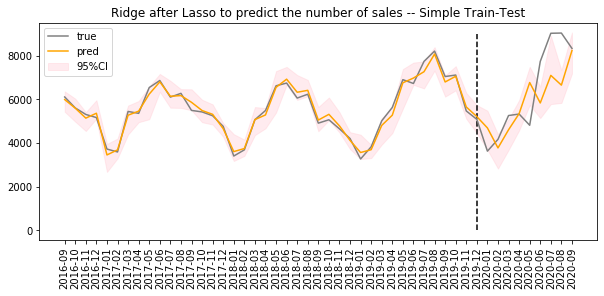

In [171]:
plt.figure(figsize=(10,4))
y_predict_mean = np.mean(np.array(y_predict),axis=0)
y_pred_upper = np.percentile(np.array(y_predict),97.5, axis=0)
y_pred_lower = np.percentile(np.array(y_predict),2.5, axis=0)

plt.plot(monthData.month[6:], merged['count_sale_target']+merged['count_sale'], label='true',color='grey')
plt.plot(monthData.month[6:], y_predict_mean+merged['count_sale'], label='pred',color='orange')
plt.fill_between(monthData.month[6:], y_pred_upper+merged['count_sale'], y_pred_lower+merged['count_sale'], color = 'pink',alpha=0.3,label='95%CI')
plt.vlines(monthData.month[6:].iloc[len(train_y['count_sale_target'])], 0, 9000, linestyles='--')
plt.title('Ridge after Lasso to predict the number of sales -- Simple Train-Test')
plt.xticks(rotation=90)
plt.legend()

In [48]:
len(train_y['count_sale_target'])

39

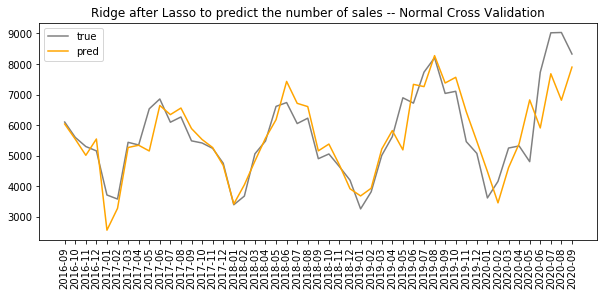

In [170]:
X_std = np.vstack((train_X_std[:,selected_features_sale_no], test_X_std[:,selected_features_sale_no]))
y_std = np.vstack((train_y, test_y))
model = sklearn.linear_model.RidgeCV()
predict = sklearn.model_selection.cross_val_predict(model, X_std, y_std[:,0],cv=5)
plt.figure(figsize=(10,4))
plt.plot(monthData.month[6:], merged['count_sale_target']+merged['count_sale'], label='true',color='grey')
plt.plot(monthData.month[6:], predict+merged['count_sale'], label='pred',color='orange')
plt.title('Ridge after Lasso to predict the number of sales -- Normal Cross Validation')
plt.xticks(rotation=90)
plt.legend()

In [220]:
groups_train, groups_test, split_idx = model_split(X_std, y_std[:,0], cv=16, return_idx=True)
split_idx

[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48]

In [221]:
model = sklearn.linear_model.RidgeCV()
#preds, scores = nested_cv_evaluation(model,X_std,y_std[:,0],cv=8)
preds, scores, upper,lower = nested_cv_evaluation(model,X_std,y_std[:,0],cv=16, show_CI_percent=95)

train time :  1
482240.2670005431
train time :  2
8294303.367127712
train time :  3
29514.3358428745
train time :  4
270517.41025821917
train time :  5
85020.3690589221
train time :  6
97906.39841769566
train time :  7
17963.108107717846
train time :  8
336024.84877586016
train time :  9
147398.87319658702
train time :  10
237539.83334454792
train time :  11
681324.9091218835
train time :  12
143149.63205093707
train time :  13
414438.76770579186
train time :  14
1610132.3131795109
train time :  15
5443784.352289245
train time :  16
227407.7670967233


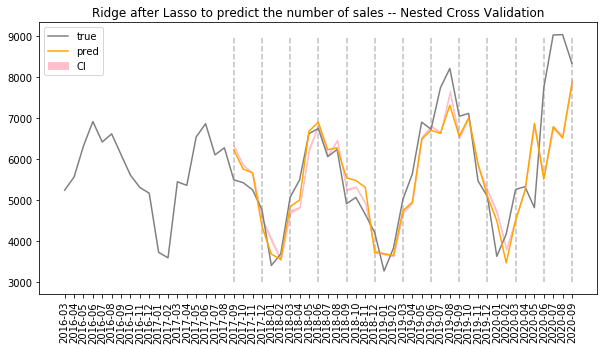

In [260]:
plt.figure(figsize=(10,5))
start_idx = 12
plt.plot(monthData.month, monthData.count_sale, label='true',color='grey')
plt.fill_between(monthData.month[6:].iloc[start_idx:], upper[start_idx-3:]+merged['count_sale'][start_idx:], lower[start_idx-3:]+merged['count_sale'][start_idx:],label='CI', color='pink', alpha=1)
plt.plot(monthData.month[6:].iloc[start_idx:], preds[start_idx-3:]+merged['count_sale'][start_idx:], label='pred',color='orange')
plt.vlines(monthData.month[6:].values[split_idx[3:]],3000,9000,linestyles='--',color='grey',alpha=0.5)
plt.title('Ridge after Lasso to predict the number of sales -- Nested Cross Validation')
plt.xticks(rotation=90)
plt.legend()

In [261]:
#mse score from 18 months
y_truth = (merged['count_sale_target']+merged['count_sale']).iloc[start_idx:]
print('The nested cross validation mse score is: ', mean_squared_error(y_truth, preds[start_idx-3:]+merged['count_sale'][start_idx:]))



The nested cross validation mse score is:  775216.492259932


### Nested cross validation -- Time series

In [231]:
#Step 1:  evaluate the time series model
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    return model

def build_variational_posteriors(model, training_data, nsamples,
                                 optimizer = tf.optimizers.Adam(learning_rate=.05),
                                 plot = True
                                ):
    # Build the variational surrogate posteriors `qs`.
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

    # Allow external control of optimization to reduce test runtimes.
    num_variational_steps = 200 # @param { isTemplate: true}
    num_variational_steps = int(num_variational_steps)
    # Using fit_surrogate_posterior to build and optimize the variational loss function.
    @tf.function(experimental_compile=True)
    def train():
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_log_prob(observed_time_series=training_data),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
        return elbo_loss_curve

    elbo_loss_curve = train()
    
    if plot:
        plt.plot(elbo_loss_curve)
        plt.title("ELBO loss curve")
        plt.show()

    # Draw samples from the variational posterior.
    q_samples = variational_posteriors.sample(nsamples)
    
    return q_samples

class BTSM(object):
    def __init__(self,):
        self.model = 0
        self.q_samples = 0
        
    def fit(self,x_train, y_train):
        self.train = x_train
        self.model = build_model(x_train)
        self.q_samples = build_variational_posteriors(self.model, x_train,len(x_train),
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = False)
        
        
    def predict(self,x_test,num_samples=500):
        forecast_dist = tfp.sts.forecast(self.model, observed_time_series=self.train,
                                            parameter_samples=self.q_samples, num_steps_forecast=len(x_test))

        forecast_mean, forecast_scale, forecast_samples = (forecast_dist.mean().numpy()[..., 0],
                                                           forecast_dist.stddev().numpy()[..., 0],
                                                           forecast_dist.sample(num_samples).numpy()[..., 0])
        return forecast_mean, forecast_scale, forecast_samples
        


In [232]:
def model_evaluation_ts(model, groups_train, groups_test, cv, show_CI_percent=None):
    scores = []
    preds = []
    upper = []
    lower = []
    for i in range(cv):
        model_copy = model
        print('train time : ', i+1)
        model_copy.fit(groups_train[i][0], groups_train[i][1])
        pred, std, samples = model_copy.predict(groups_test[i][0])
        mse = mean_squared_error(groups_test[i][1], pred)
        scores.append(mse)
        print(mse)
        preds.extend(list(pred))
        if show_CI_percent!=None:
            upper.extend(list(np.percentile(np.array(samples),100-show_CI_percent/2, axis=0)))
            lower.extend(list(np.percentile(np.array(samples),show_CI_percent/2, axis=0)))
    if show_CI_percent == None:
        return preds, scores
    else:
        return np.array(preds), scores, np.array(upper), np.array(lower)

def nested_cv_evaluation_ts(model,x,y,cv=5, start_pred=3, show_CI_percent = None):
    if show_CI_percent == None:
        groups_train, groups_test = model_split(x,y,cv)
        preds, scores = model_evaluation_ts(model, groups_train, groups_test, cv)
        return preds, scores
    else:
        groups_train, groups_test = model_split(x,y,cv)
        preds, scores, upper, lower = model_evaluation_ts(model, groups_train, groups_test,cv, show_CI_percent)
        return preds, scores, upper, lower



In [234]:
monthData.head()

,Unnamed: 0,count_list,month,count_sale,sale_price
0,0,12885.0,2016-03,5234,2.059187e+09
1,1,10650.0,2016-04,5555,2.242159e+09
2,2,9334.0,2016-05,6311,2.627671e+09
3,3,9515.0,2016-06,6908,2.962638e+09
4,4,8163.0,2016-07,6408,2.684241e+09


In [235]:
monthData.tail()

,Unnamed: 0,count_list,month,count_sale,sale_price
50,50,14520.0,2020-05,4805,2.379073e+09
51,51,14574.0,2020-06,7728,3.903482e+09
52,52,14901.0,2020-07,9019,4.842772e+09
53,53,13734.0,2020-08,9029,4.808662e+09
54,54,13626.0,2020-09,8325,4.464710e+09


In [237]:
sales = monthData['count_sale'].values.astype(float)
lists = monthData['count_list'].values.astype(float)

In [239]:
merged.head()

,count_list,month,count_sale,sale_price,homes for sale,townhomes for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,...,05m,06m,07m,08m,09m,10m,11m,12m,count_sale_target,count_list_target
3,9515.0,2016-06,6908,2.962638e+09,59.772373,92.568674,81.728430,55.884988,5.284968,13.172702,...,0,1,0,0,0,0,0,0,-807.0,-2575.0
4,8163.0,2016-07,6408,2.684241e+09,61.815081,95.738568,84.635856,40.320925,4.728896,18.482621,...,0,0,1,0,0,0,0,0,-809.0,-2796.0
5,7690.0,2016-08,6607,2.716282e+09,49.269667,55.532880,63.621405,82.316527,4.496565,16.339958,...,0,0,0,1,0,0,0,0,-1307.0,-3725.0
6,6940.0,2016-09,6101,2.457247e+09,38.933788,24.458258,42.838747,43.324917,8.171971,22.679009,...,0,0,0,0,1,0,0,0,-943.0,-4174.0
7,5367.0,2016-10,5599,2.261839e+09,28.381404,25.461185,39.078552,57.093753,3.720349,11.200653,...,0,0,0,0,0,1,0,0,-1884.0,-1382.0


In [238]:
groups_train, groups_test, split_idx = model_split(sales, sales, cv=16, return_idx=True)
split_idx

[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48]

In [242]:
bmodel = BTSM()
preds_ts,scores_ts, upper_ts, lower_ts = nested_cv_evaluation_ts(bmodel,sales,sales,cv=16,show_CI_percent=95)

train time :  1
228340.75354428377
train time :  2
2617979.4063727986
train time :  3
4055736.3553388617
train time :  4
5012625.291873679
train time :  5
128294.14639845329
train time :  6
62243.80488467786
train time :  7
52783.683959861584
train time :  8
52575.28588611994
train time :  9
140179.3523502257
train time :  10
198978.3359275622
train time :  11
214821.14456047537
train time :  12
102967.4315303345
train time :  13
1876975.908150561
train time :  14
1577067.9803131067
train time :  15


535994.3348347736
train time :  16
5409830.76996743


In [243]:
len(preds_ts)

52

The nested cross validation mse score is:  1181949.0362028661


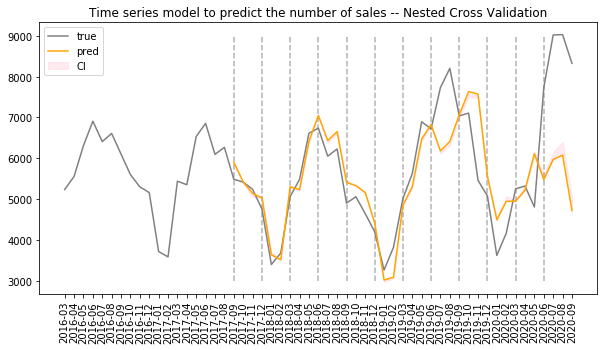

In [270]:
print('The nested cross validation mse score is: ', np.mean(scores_ts[3:]))
start_idx = 15
plt.figure(figsize=(10,5))
plt.plot(monthData.month, list(sales),label ='true', color='grey')
plt.plot(monthData.month[3:].iloc[start_idx:], preds_ts[start_idx:],label='pred', color='orange')
plt.fill_between(monthData.month[3:].iloc[start_idx:], upper_ts[start_idx:], lower_ts[start_idx:],label='CI', color='pink', alpha=0.3)
plt.vlines(monthData.month[3:].values[split_idx[4:]],ymin=3000, ymax=9000,alpha=0.3,linestyle='--')
plt.title('Time series model to predict the number of sales -- Nested Cross Validation')
plt.xticks(rotation=90)
plt.legend()

In [273]:
#mse score from 18 months
y_truth = sales[start_idx+3:]
print('The nested cross validation mse score is: ', mean_squared_error(y_truth, preds_ts[start_idx:]))


The nested cross validation mse score is:  1413853.437215273


## Update 2: Stacking
### Stacking 1: BSTS model

### Stacking 2: Linear Combination

In [277]:
#linear combination
y = sales[start_idx+3:]
x1 = preds_ts[start_idx:]
x2 = preds[12-3:]+merged['count_sale'][12:]
lr = LinearRegression()
lr.fit(np.concatenate([[x1],[x2]]).T, y)
print(lr.coef_)
print(lr.intercept_)
coefs = lr.coef_
intercept = lr.intercept_
lr.score(np.concatenate([[x1],[x2]]).T, y)

[-0.00768801  1.0692696 ]
-143.87107855362137


0.6848069953432462

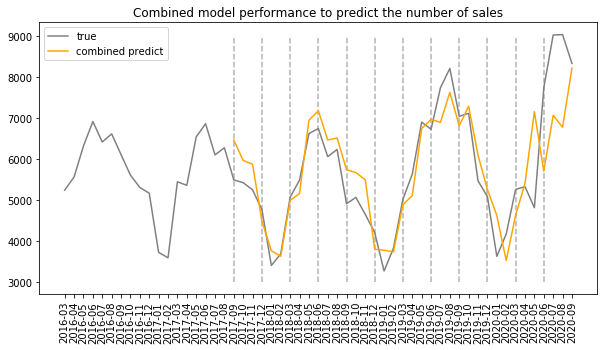

In [281]:
#final prediction
prediction = coefs[0]*np.array(x1)+coefs[1]*np.array(x2)+intercept
plt.figure(figsize=(10,5))
plt.plot(monthData.month, list(sales),label ='true', color='grey')
plt.plot(monthData.month[3:].iloc[start_idx:], prediction,label='combined predict',color='orange')
plt.vlines(monthData.month[3:].values[split_idx[4:]],ymin=3000, ymax=9000,alpha=0.3,linestyle='--')
plt.title('Combined model performance to predict the number of sales')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months


In [282]:
#print('The nested cross validation mse score is: ', mean_squared_error(y_truth, preds_ts[start_idx-6:]))
print('The mse in time series model :', mean_squared_error(y,x1))
print('The mse in google trends model :', mean_squared_error(y,x2))
print('The mse in combined model :', mean_squared_error(y,prediction))

The mse in time series model : 1413853.437215273
The mse in google trends model : 775216.492259932
The mse in combined model : 730608.8568550621
